## Intro

Fastai2 provides a wide range of data augmentation techniques and this blog is particularly focused on image 
augmentation techniques (This is a update to the article 'Data Augmentation Techniques' I wrote in 2018 using fastai v1<sup>[1]</sup>)

Working with limited data has its own challenges, using data augmentation can have positive results only 
if the augmentation techniques enhance the current data set for example is there any worth is training a 
network to ‘learn’ about a landmark in a flipped upside down orientation?

<b>Invariance</b> is the ability of convolutional neural networks to classify objects even when they are placed in different 
orientations. Data augmentation is a way of creating new ‘data’ with different orientations. The benefits of this are 
two fold, the first being the ability to generate ‘more data’ from limited data and secondly it prevents over fitting.

Most deep learning libraries use a step by step method of augmentation whilst <b>*fastai2 utilizes methods that combine various 
augmentation parameters to reduce the number of computations and reduce the number of lossy operations*</b><sup>[2]</sup>.

Fastai uses <b>Pipelines</b> to compose several transforms together.  A *Pipeline* is defined by passing a list of Transforms and it will then compose the transforms inside it.  In this blog I will look at what order these transforms are conducted and what effect they have on image quality and efficiency.

<b>Using this as a high-level API example</b>

In [134]:
from fastai2.vision.all import*
source = untar_data(URLs.PETS)

In [97]:
#High-level API example
testblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=[Resize(256)],
                 batch_tfms=[*aug_transforms(xtra_tfms=None)])
test_dls = testblock.dataloaders(source/'images')

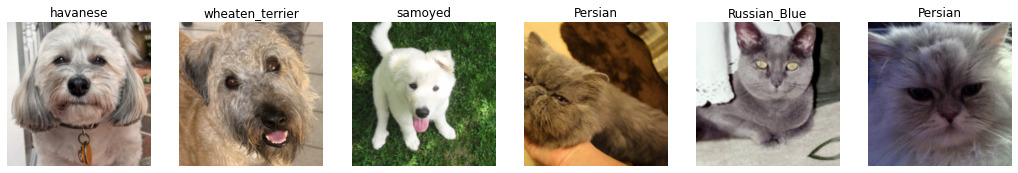

In [169]:
test_dls.show_batch(max_n=6, nrows=1, ncols=6)

To check the order of how augementations are conducted we can call <b>*after_item*</b> and <b>*after_batch*</b>

## after_item

In [6]:
test_dls.after_item

Pipeline: Resize -> ToTensor

In this case images are:
> <b>resized to sizes of equal length, in this case 256 and then</b>

> <b>transform the image into float tensors divided by 255</b>

### But what does Resize do?

Click the button to view the <b>Resize</b> class

In [128]:
#collapse
#https://github.com/fastai/fastai2/blob/master/nbs/09_vision.augment.ipynb
@delegates()
class Resize(RandTransform):
    split_idx = None
    mode,mode_mask,order,final_size = Image.BILINEAR,Image.NEAREST,1,None
    "Resize image to `size` using `method`"
    def __init__(self, size, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection,
                 resamples=(Image.BILINEAR, Image.NEAREST), **kwargs):
        super().__init__(**kwargs)
        self.size,self.pad_mode,self.method = _process_sz(size),pad_mode,method
        self.mode,self.mode_mask = resamples

    def before_call(self, b, split_idx):
        if self.method==ResizeMethod.Squish: return
        self.pcts = (0.5,0.5) if split_idx else (random.random(),random.random())

    def encodes(self, x:(Image.Image,TensorBBox,TensorPoint)):
        orig_sz = _get_sz(x)
        self.final_size = self.size
        if self.method==ResizeMethod.Squish:
            return x.crop_pad(orig_sz, Tuple(0,0), orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

        w,h = orig_sz
        op = (operator.lt,operator.gt)[self.method==ResizeMethod.Pad]
        m = w/self.size[0] if op(w/self.size[0],h/self.size[1]) else h/self.size[1]
        cp_sz = (int(m*self.size[0]),int(m*self.size[1]))
        tl = Tuple(int(self.pcts[0]*(w-cp_sz[0])), int(self.pcts[1]*(h-cp_sz[1])))
        return x.crop_pad(cp_sz, tl, orig_sz=orig_sz, pad_mode=self.pad_mode,
                   resize_mode=self.mode_mask if isinstance(x,PILMask) else self.mode, resize_to=self.size)

By default resize *'squishes'* the image to the size specified. The image is resized so that the shorter dimension matches
the size specifed and the rest padded with what is specified in <b>pad_mode</b>.

The method parameter can be be 1 of 3 values: <b>Crop</b>, <b>Pad</b> or <b>Squish(default)</b> eg: <b>*method=ResizeMethod.Squish*</b>
The padding parameter also takes 1 of 3 values: <b>Border</b>, <b>Zeros</b> and <b>Reflection(default)</b>  eg: <b>*pad_mode=PadMode.Reflection*</b>.

The images are resized/resamples using bilinear and nearest neighbour interprolations<sup>[3]</sup>.

We can check to see how initial image sizes are affected by Resize. I choose an image with numbers so that you can see
different areas of the image easier and I colored each of the corners a different color to better see what effects 
Resize has on the image.

In [130]:
#Load a test image
image_path = 'C:/Users/avird/.fastai/data/0100-number_12.jpg'
img = Image.open(image_path)
img.shape, type(img)

((380, 500), PIL.JpegImagePlugin.JpegImageFile)

In [131]:
#Convert image into a fastai.PILImage
img = PILImage(PILImage.create(image_path).resize((500,380)))
img.shape, type(img)

((380, 500), fastai2.vision.core.PILImage)

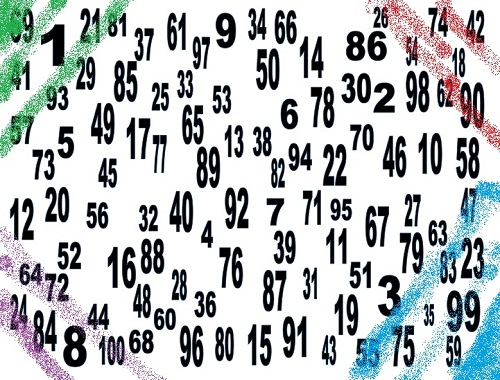

In [132]:
#View the image
img

Plot 1 image each for each of the 3 types of ResizeMethod (Squish is default). For Padding I changed to PadMode.Zeros
(default is Reflection)

<b>*> Image size 5*</b>

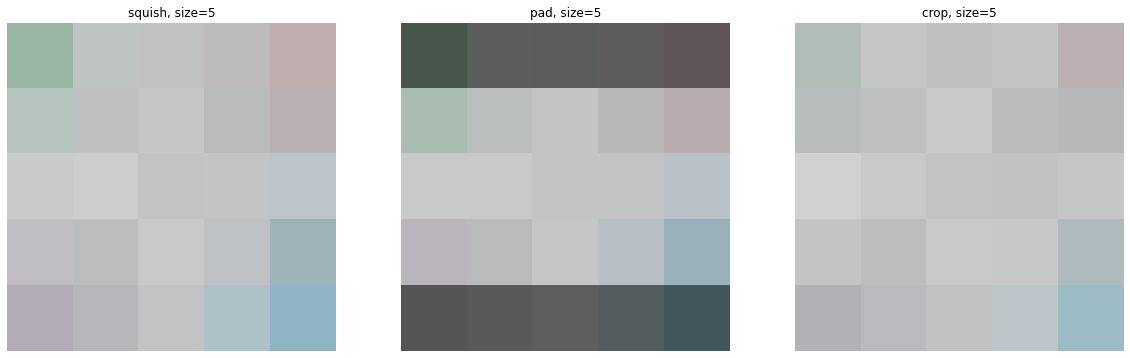

In [135]:
#collapse
#Use image size of 5
_,axs = plt.subplots(1,3,figsize=(20,20))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(5, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img, split_idx=1), ctx=ax, title=f'{method}, size=5');

Using an image size of 5 we can see how the image is affected by Resize. Here is we can still see the 4 different colors
in each corner.  With pad we can see that the image is being resized so the shorter dimension is matched to the image size
and then padded with zeros. With crop the image is cropped from the center.

A RandTransform is applied to the training set by default (split_idx=0), to specify the validation set you change to split_idx=1.

<b>*> Image size 15*</b>

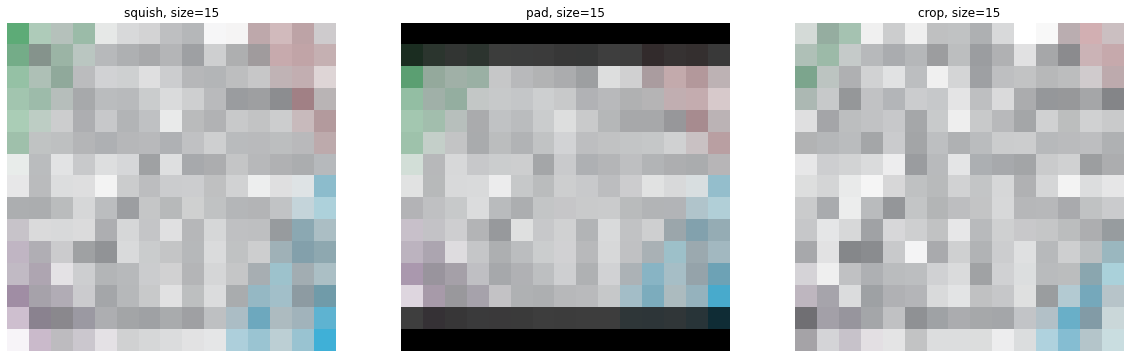

In [125]:
#collapse
#Use image size of 15
_,axs = plt.subplots(1,3,figsize=(20,20))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(15, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img, split_idx=1), ctx=ax, title=f'{method}, size=15');

<b>*> Image size 256*</b>

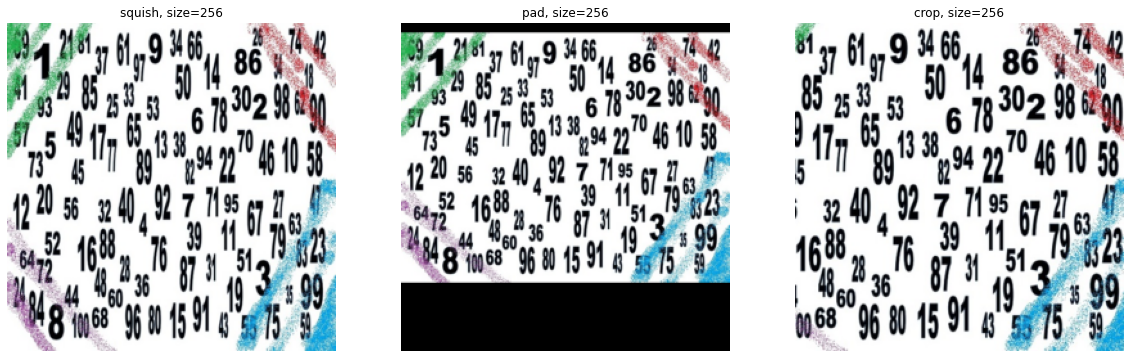

In [78]:
#collapse
#Use image size of 256
_,axs = plt.subplots(1,3,figsize=(20,20))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img, split_idx=0), ctx=ax, title=f'{method}, size=256');


<b>What impacts could this have on real datasets.</b>

Using an image from a Covid19 dataset <sup>[5]</sup>

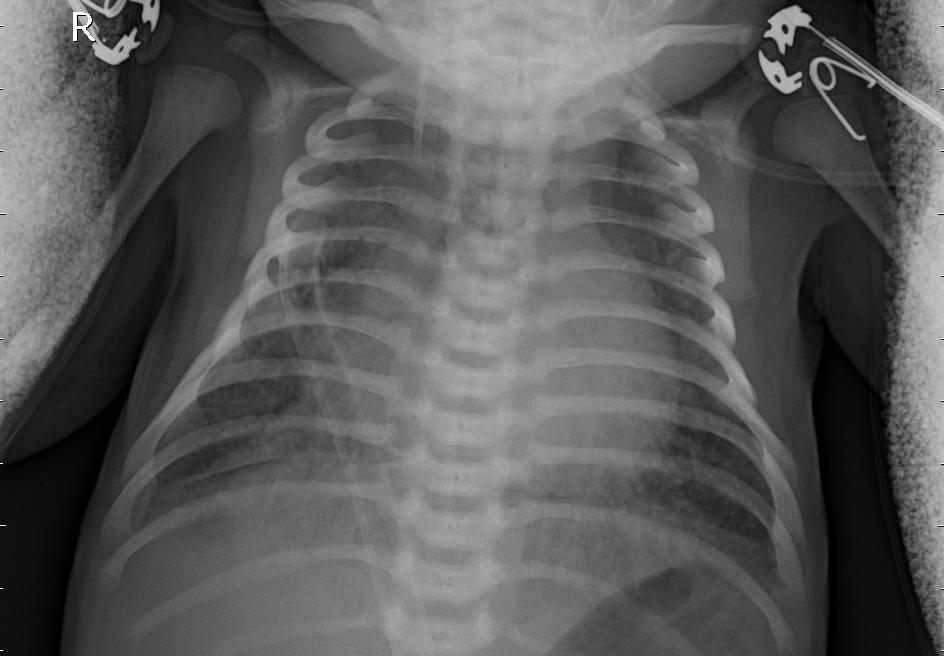

In [79]:
#collapse
test_path = 'C:/Users/avird/.fastai/data/0002.jpeg'
testimg = Image.open(test_path)
img2 = PILImage(PILImage.create(test_path).resize((944, 656)))
img2

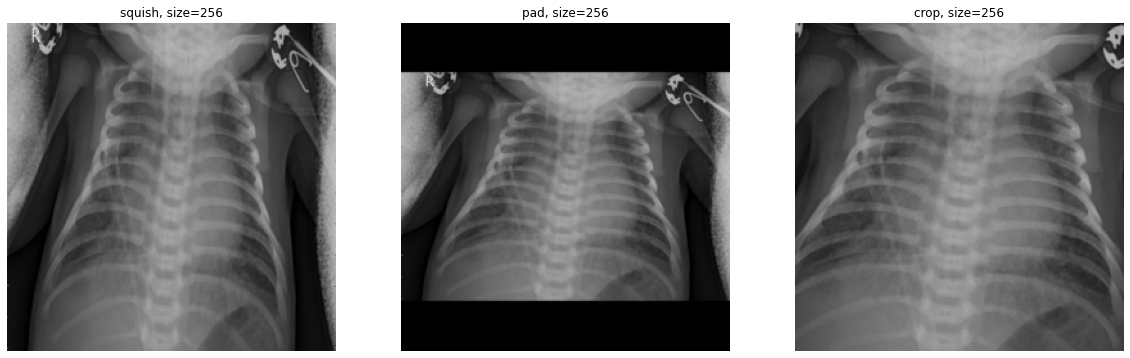

In [81]:
#collapse
#Use image size of 256
_,axs = plt.subplots(1,3,figsize=(20,20))
for ax,method in zip(axs.flatten(), [ResizeMethod.Squish, ResizeMethod.Pad, ResizeMethod.Crop]):
    rsz = Resize(256, method=method, pad_mode=PadMode.Zeros)
    show_image(rsz(img2, split_idx=1), ctx=ax, title=f'{method}, size=256');

In this case:

> the default squish resize method squishes the image on the horizontal axis. You can view the whole image however you can see that ribcage is contricted.

> for the pad resize the image is still viewable fully but the image has been squished on the vertical axis.

> With Crop, the image is cropped from the centre hence we lose the image from the edges

## after_batch

Back to the pets example if we run <b>*after_batch*</b>, this shows us the after batch augmentation pipeline.  Previously item_tfms is used to resize the images and to collate them into tensors ready for GPU processing.

In [82]:
test_dls.after_batch

Pipeline: IntToFloatTensor -> AffineCoordTfm -> LightingTfm

This reveals the pipeline process for the batch transformations:

> <b>convert ints to float tensors</b>

> <b>apply all the affine transformations</b>

> <b>followed by the lighting transformations</b> 

The order is important in order to maintain a number of key aspects:

> <b>Maintain image quality</b>

> <b>Reduce computations</b>

> <b>Improve efficiency</b>

As mentioned in <b>Fastbook</b> <sup>[4]</sup>, most machine libraries use a step by step process of augmentation which can lead to a reduced quality of images.  The datablock example above is an example of a high-level API which is pretty flexible but not as much as a mid-level API. 

<b>The mid-level datablock below is an exact example of the high-level datablock above and allows for more customizations.</b>

In [105]:
#collapse
#Helper for viewing single images
def repeat_one(source, n=128):
    """Single image helper for displaying batch"""
    return [get_image_files(source)[1]]*n

In [107]:
#mid-level API example 
#num_workers = 0 because I use windows :) and windows does not support multiprocessing on CUDA [6]
tfms = [[PILImage.create], [using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), Categorize]]
item_tfms = [ToTensor(), Resize(256)]
splitter=RandomSplitter(seed=42)
after_b = [IntToFloatTensor(), *aug_transforms(xtra_tfms=None)]

dsets = Datasets(repeat_one(source/'images'), tfms=tfms)
dls = dsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

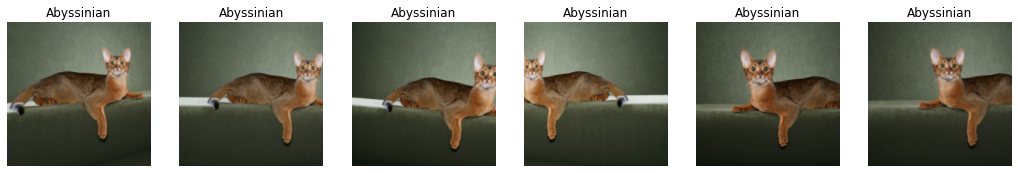

In [188]:
#collapse
dls.show_batch(max_n=6, nrows=1, ncols=6)

### Image comparisons (Fastai v The Rest)

In [189]:
#create 1 batch
x,y = dls.one_batch()

> <b>Checking image quality and speed using step by step transformations.</b>

Wall time: 103 ms


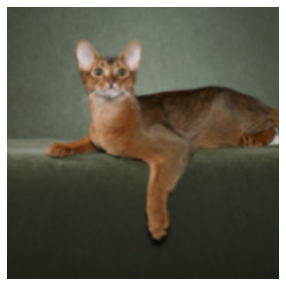

In [198]:
#collapse
time
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=256)
x1 = x1.brightness(max_lighting=0.2, p=1.)
x1 = x1.zoom(max_zoom=1.1, p=0.5)
x1 = x1.warp(magnitude=0.2, p=0.5)

_,axs = subplots(1, 1, figsize=(5,5))
TensorImage(x1[0]).show(ctx=axs[0])

> <b>Checking image quality and speed using fastai2</b>

Wall time: 45.9 ms


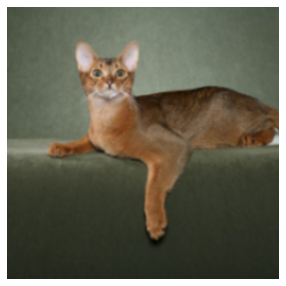

In [199]:
#collapse
%%time
tfms = setup_aug_tfms([Brightness(max_lighting=0.2, p=1.,),
                       CropPad(size=256),
                       Zoom(max_zoom=1.1, p=0.5),
                       Warp(magnitude=0.2, p=0.5)
                      ])
x = Pipeline(tfms)(x)
_,axs = subplots(1, 1, figsize=(5,5))
TensorImage(x[0]).show(ctx=axs[0])

Comparing the times above using a pipeline where a list of transforms are passed in is nearly twice as fast as using augmentations step by step. 
In this case the step by step method completed the task in <b>103ms</b> compard to <b>46s</b> using fastai

Looking at side by side look at image quality

In [100]:
#collapse
image_comp():
    x,y = dls.one_batch()
    tfms = setup_aug_tfms([Brightness(max_lighting=0.3, p=1.,),
                       Resize(size=256),
                       Zoom(max_zoom=1.1, p=1.),
                       Warp(magnitude=0.2, p=1.)
                      ])
    x = Pipeline(tfms)(x)

    x1 = TensorImage(x.clone())
    x1 = x1.affine_coord(sz=256)
    x1 = x1.brightness(max_lighting=0.3, p=1.)
    x1 = x1.zoom(max_zoom=1.1, p=1.)
    x1 = x1.warp(magnitude=0.2, p=1.)

    _,axs = subplots(1, 2, figsize=(20,20))
    TensorImage(x[0]).show(ctx=axs[0], title='fastai')
    TensorImage(x1[0]).show(ctx=axs[1], title='other')

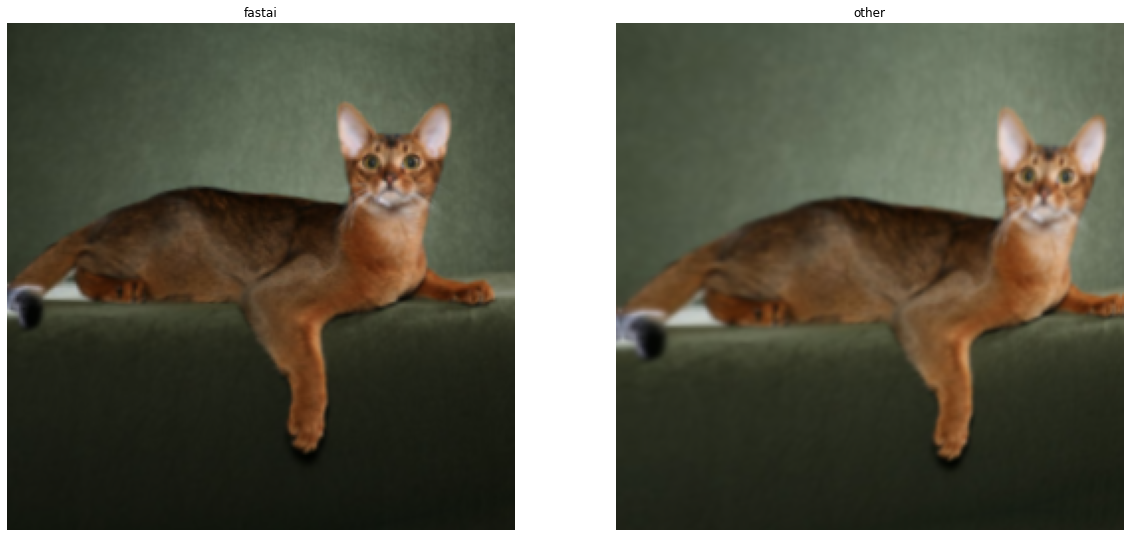

In [101]:
image_comp()

You can definately see differences between the two pictures, the 'fastai' image is more clearer compared to the 'other' image.  How about some other examples

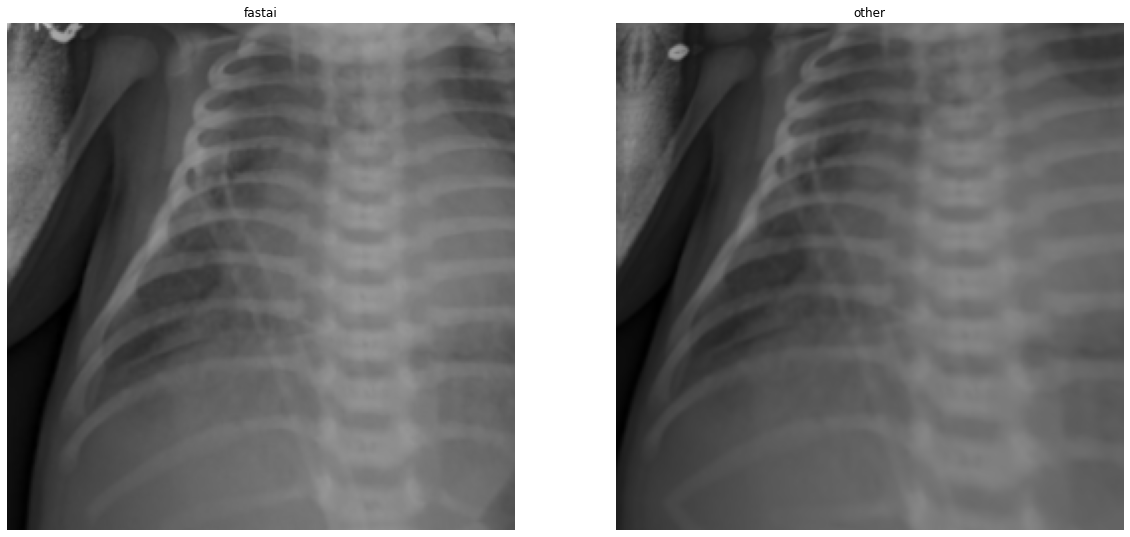

In [104]:
image_comp()

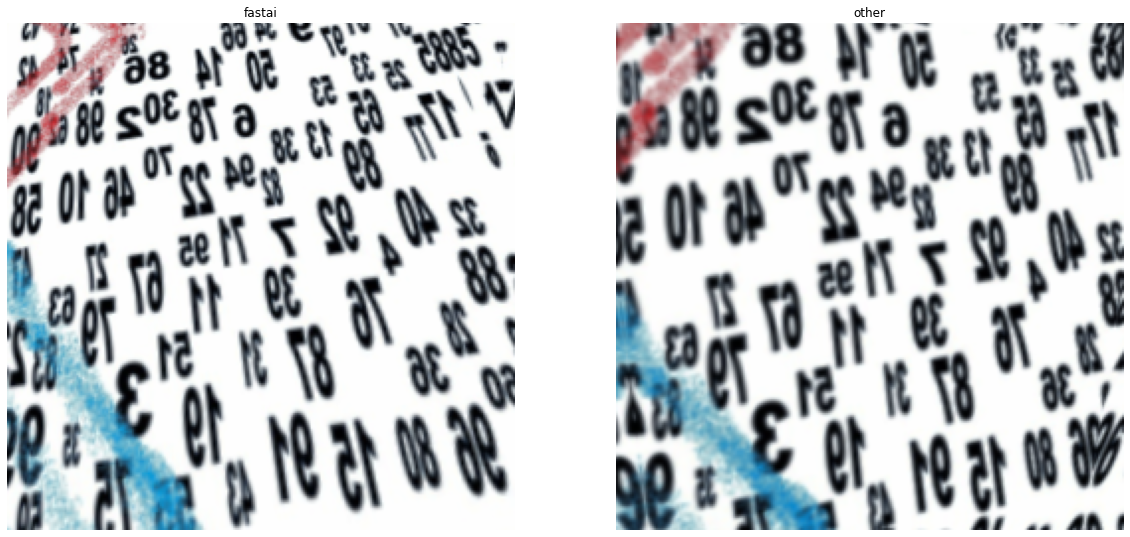

In [110]:
image_comp()

## List of Transforms

<b>RandomResizedCrop</b> = "Picks a random scaled crop of an image and resize it to `size` - order 1"<br/>
<b>IntToFloatTensor</b> = "Transform image to float tensor, optionally dividing by 255 (e.g. for images) - order 10<br/>
<b>Rotate</b> = "Apply a random rotation of at most `max_deg` with probability `p` to a batch of images"<br/>
<b>Brightness</b> = "Apply change in brightness of `max_lighting` to batch of images with probability `p`."<br/>
<b>RandomErasing</b> = "Randomly selects a rectangle region in an image and randomizes its pixels." - order 100<br/>
<b>CropPad</b> = "Center crop or pad an image to `size`" - order 0<br/>
<b>Zoom</b> = "Apply a random zoom of at most `max_zoom` with probability `p` to a batch of images"<br/>
<b>Warp</b> = "Apply perspective warping with `magnitude` and `p` on a batch of matrices"<br/>
<b>Contrast</b> = "Apply change in contrast of `max_lighting` to batch of images with probability `p`."<br/>

### Pipeline for multiple augmentations

In the example above the after_batch pipeline consisted of IntToFloatTensor > Affine tranformations > Lighting transformations.  

What if we use numerous augmentations, what does the pipeline look like then?

In [115]:
#collapse
source = untar_data(URLs.PETS)
#Helper for viewing single images
def repeat_one(source, n=128):
    """Single image helper for displaying batch"""
    return [get_image_files(source)[2]]*n

In [118]:
#collapse
#Include multiple transforms
tfms = [[PILImage.create], [using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'), Categorize]]
item_tfms = [ToTensor(), Resize(296)]
splitter=RandomSplitter(seed=42)
xtra_tfms = [Rotate(max_deg=45, p=1.),
            RandomErasing(p=1., max_count=10, min_aspect=0.5, sl=0.2, sh=0.2),
            RandomResizedCrop(p=1., size=256),
            Brightness(max_lighting=0.2, p=1.),
            CropPad(size=256),
            Zoom(max_zoom=2.1, p=0.5),
            Warp(magnitude=0.2, p=1.0)
            ]
after_b = [IntToFloatTensor(), *aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=0., 
           max_zoom=1.1, max_lighting=0.,max_warp=0., p_affine=0.75, p_lighting=0.75, xtra_tfms=xtra_tfms, size=256,
           mode='bilinear', pad_mode=PadMode.Reflection, align_corners=True, batch=False, min_scale=0.9)]

mdsets = Datasets(repeat_one(source/'images'), tfms=tfms)
mdls = mdsets.dataloaders(after_item=item_tfms, after_batch=after_b, bs=32, num_workers=0, splits=splitter)

Looking at after_item - it is the same as before

In [429]:
mdls.after_item

Pipeline: Resize -> ToTensor

In [430]:
mdls.after_batch

Pipeline: CropPad -> IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> RandomErasing

<b>after_batch</b> is now a different story and we can see the list of how fastai computes its augmentations. These are all done in sequence (depending on their order) starting with 
>CropPad

>followed by affine

>lighting

>and random erasing transforms. 

Here is what the batch looks like

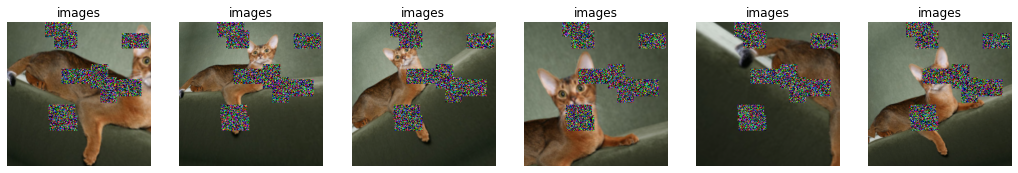

In [431]:
mdls.show_batch(max_n=6, nrows=1, ncols=6)

The order number determines the sequence of the transforms for example CropPad is <b>order 0</b>, Resize and RandomCrop are <b>order 1</b> hence the reason they appear first on the list. IntToFloatTensor is <b>order 10</b> and runs after PIL transforms on the GPU.  Affine transforms are <b>order 30</b> and so is RandomResizedCropGPU and lighting transforms are <b>order 40</b>. RandomErasing is <b>order 100</b>. 

### Interesting Observations

There were some interesting observations during this experimention. Adding a <b>*min_scale*</b> value in <b>aug_transforms</b> adds <b>RandomResizedCropGPU</b> to the *pipeline*

In [433]:
mdls.after_batch

Pipeline: CropPad -> IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> RandomErasing

However if you add <b>RandomResizedCrop</b> as well as a <b>min_scale</b> value the *pipeline* now looks like this

In [119]:
mdls.after_batch

Pipeline: RandomResizedCrop -> CropPad -> IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm -> RandomErasing

And if you use <b>RandomResizedCrop</b> with *no* <b>min_scale</b> value the pipeline is now:

In [437]:
mdls.after_batch

Pipeline: RandomResizedCrop -> CropPad -> IntToFloatTensor -> AffineCoordTfm -> LightingTfm -> RandomErasing

### *Still to do*

There is clearly a plethora of options and additonal experimentation is needed to see what the impact of the various pipelines are on image quality, efficiency and end results -<b>*work in progress*</b>

### Manually going through the pipeline

Attempt to manually go throught the pipeline. 

In [121]:
#collapse
image_path = 'C:/Users/avird/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'
TEST_IMAGE = Image.open(image_path)
img = PILImage(PILImage.create(image_path))
img.shape, type(img)                

((400, 600), fastai2.vision.core.PILImage)

This is the original image of size 400 height and 600 width

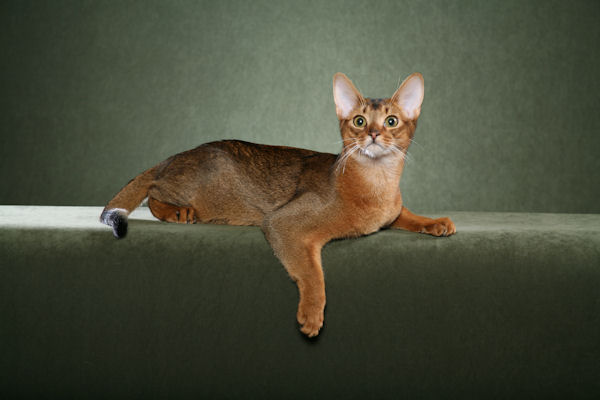

In [25]:
#collapse
#Original Image
img

Resize to 256 using default crop and reflection padding

In [38]:
#collapse
#Resize to 256 using default crop and reflection padding
r = Resize(256, method=ResizeMethod.Crop, pad_mode=PadMode.Reflection)
w = r(img)
w.shape, type(w)

((256, 256), fastai2.vision.core.PILImage)

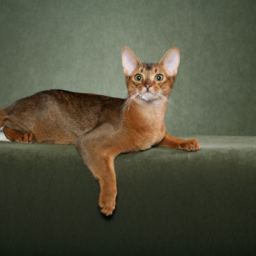

In [28]:
#collapse
w

Crop the image using size 256

In [36]:
#collapse
Crop
crp = CropPad(256)
c = r(crp(img))
c.shape, type(c)

((256, 256), fastai2.vision.core.PILImage)

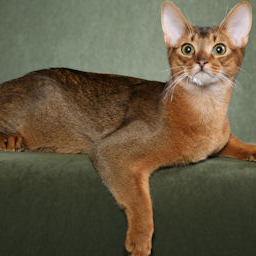

In [37]:
#collapse
c

Convert PILImage into a TensorImage

In [39]:
timg = TensorImage(array(c)).permute(2,0,1).float()/255.
timg.shape, type(timg)

(torch.Size([3, 256, 256]), fastai2.torch_core.TensorImage)

In [40]:
h = TensorImage(timg[None].expand(3, *timg.shape).clone())
h.shape, type(h)

(torch.Size([3, 3, 256, 256]), fastai2.torch_core.TensorImage)

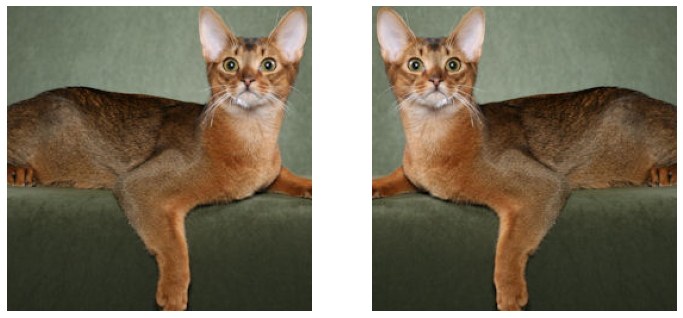

In [44]:
#if do_flip=true and flip-vert=false = Flip
fli = Flip(p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y = fli(h)
    show_image(y[0], ctx=ax, cmap='Greys')

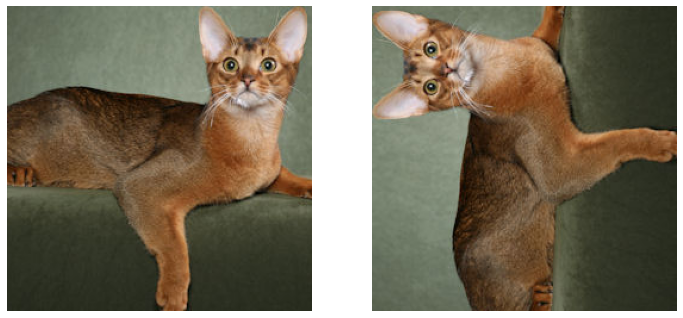

In [51]:
#if do_flp=true and flip_vert=true = dihyderal
dih = Dihedral(p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y1 = dih(h)
    show_image(y1[0], ctx=ax)

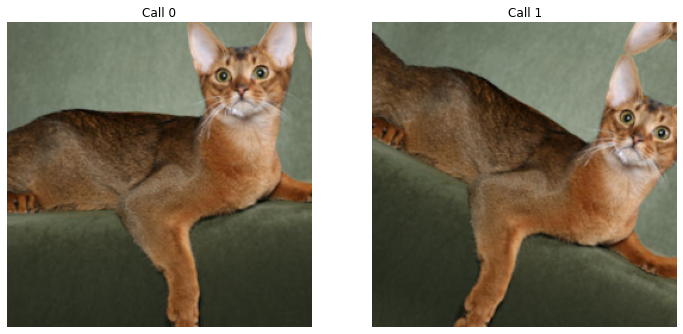

In [55]:
#Rotate 
rot = Rotate(max_deg=45, p=1.)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y2 = rot(h)
    show_image(y2[0], ctx=ax, title=f'Call {i}')

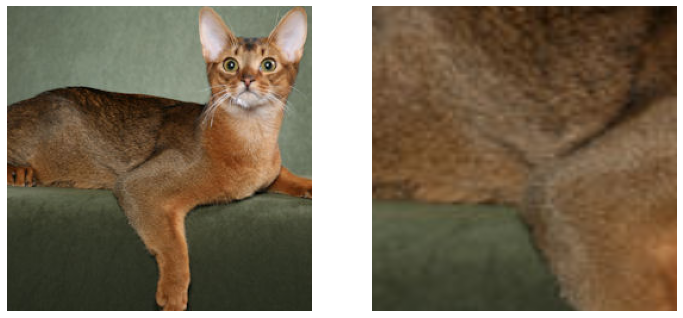

In [57]:
# Zoom
zoo = Zoom(max_zoom=4.1, p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y3 = zoo(h)
    show_image(y3[0], ctx=ax)

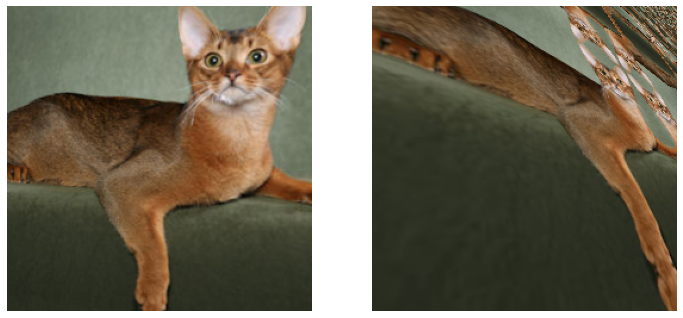

In [63]:
# Warp
war = Warp(magnitude=0.7, p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y4 = war(h)
    show_image(y4[0], ctx=ax)

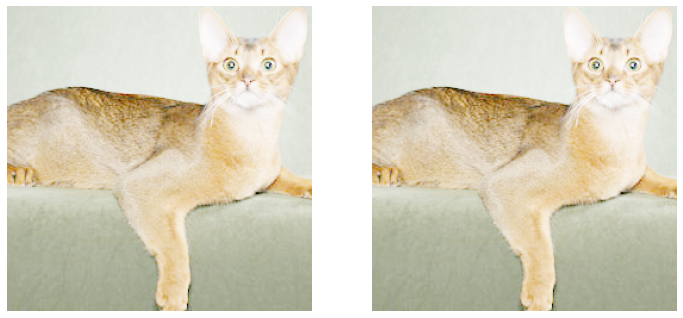

In [64]:
#Brightness
bri = h.brightness(draw=0.9, p=1.)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y5 = bri
    show_image(y5[0], ctx=ax)

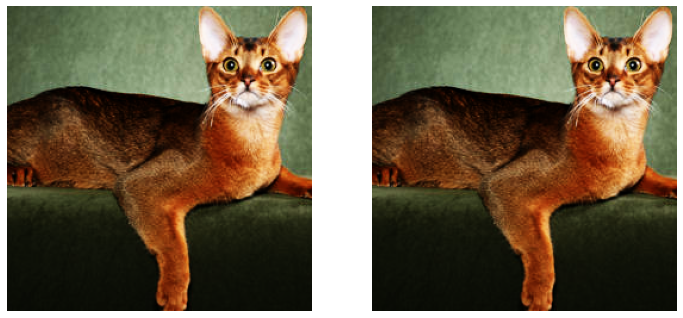

In [66]:
#Contrast
con = h.contrast(draw=1.9, p=0.5)
_,axs = plt.subplots(1,2, figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
    y6 = con
    show_image(y6[0], ctx=ax)

View the images side by side

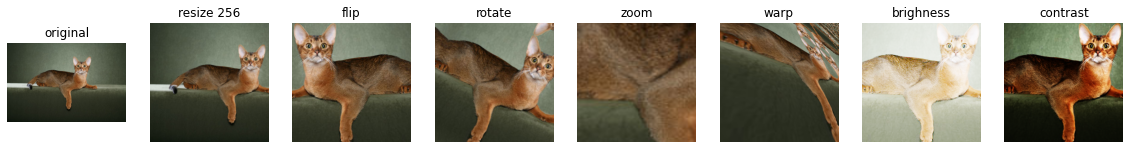

In [67]:
#collapse
_,axs = plt.subplots(1,8, figsize=(20,9))
for i,ax in enumerate(axs.flatten()):
    y7 = y1 + y4
    show_image(img, ctx=axs[0], title='original')
    show_image(w, ctx=axs[1], title='resize 256')
    show_image(y[0], ctx=axs[2], title='flip')
    show_image(y2[0], ctx=axs[3], title='rotate')
    show_image(y3[0], ctx=axs[4], title='zoom')
    show_image(y4[0], ctx=axs[5], title='warp')
    show_image(y5[0], ctx=axs[6], title='brighness')
    show_image(y6[0], ctx=axs[7], title='contrast')

### References:

<a name="1">1</a>: https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b

<a name="2">2</a>: https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb

<a name="3">3</a>: https://github.com/fastai/fastai2/blob/master/nbs/09_vision.augment.ipyn

<a name="4">4</a>: https://github.com/fastai/fastbook

<a name="5">5</a>: https://github.com/lindawangg/COVID-Net

<a name="6">6</a>: https://forums.fast.ai/t/windows-runtimeerror-cuda-runtime-error-801-runtimeerror-expected-object-of-scalar-type-long-but-got-scalar-type/57333